### 2 Body Problem Equal Masses

barycentric: 0.0%
jacobi: 0.0%
whds: 0.0%
democraticheliocentric: 0.0%


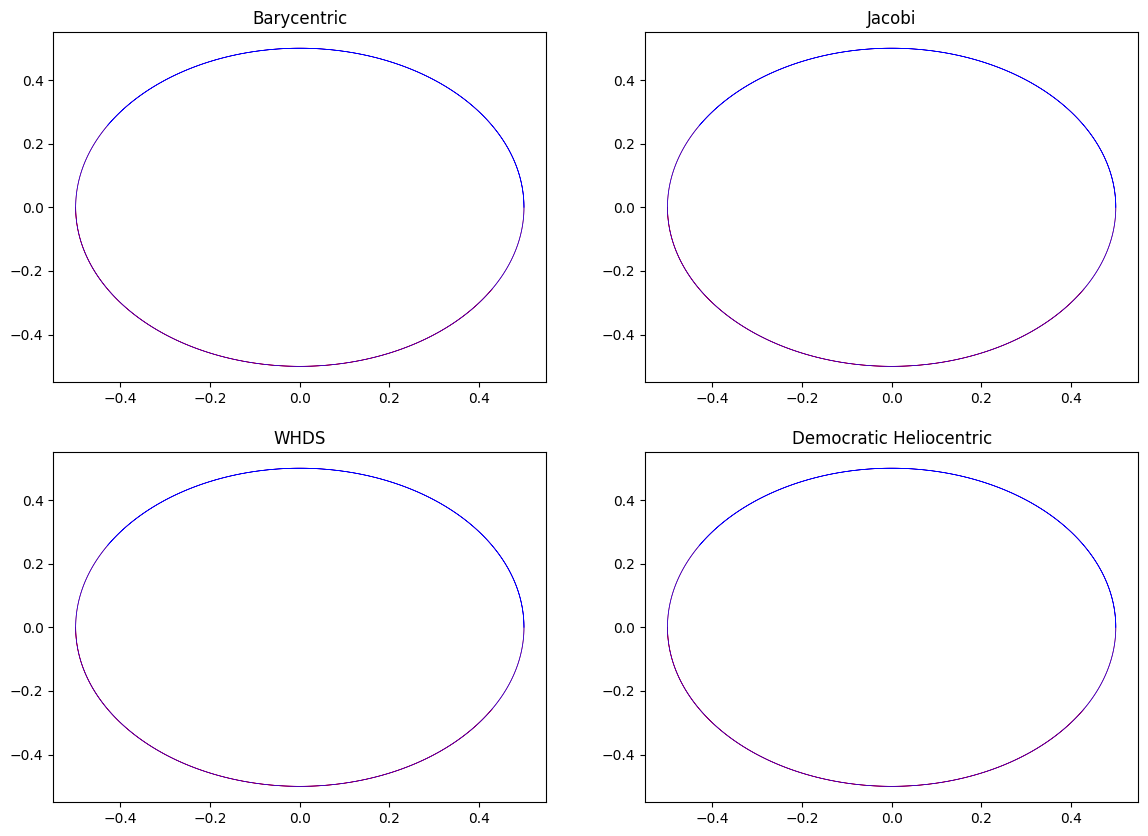

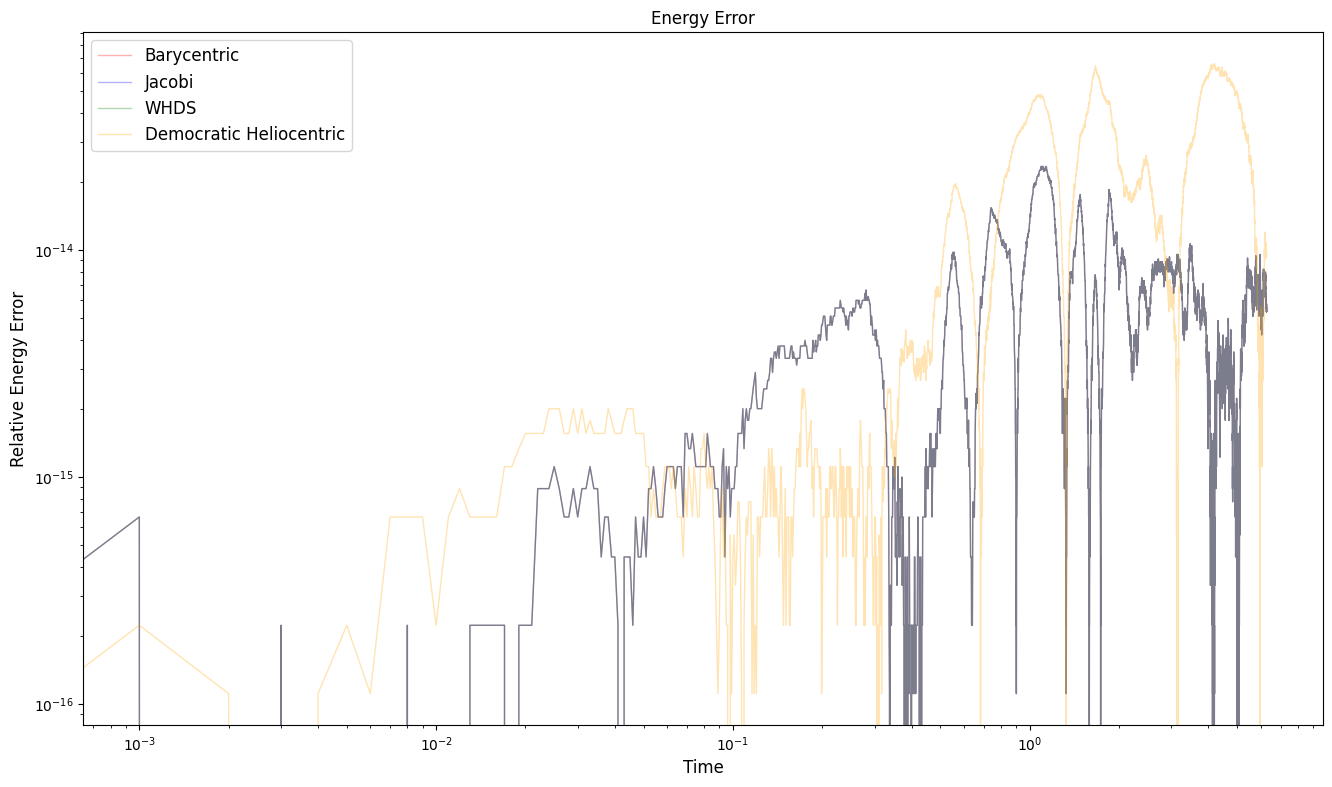

In [15]:
import rebound
import numpy as np
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor

n_orbits = 1
dt =1e-3
times = np.arange(0,n_orbits*(2*np.pi), dt)
coordinates=["barycentric","jacobi","whds","democraticheliocentric"]
errors = np.zeros((len(coordinates),len(times)))
x0 = np.zeros((len(coordinates),len(times)))
y0 = np.zeros((len(coordinates),len(times)))
x1 = np.zeros((len(coordinates),len(times)))
y1 = np.zeros((len(coordinates),len(times)))
def run_sim(coord):
    sim = rebound.Simulation()
    sim.integrator = "whfast"
    c = coordinates.index(coord)
    sim.add(m=1.)
    sim.add(m=1.,a=1.,e=0.0)
    sim.move_to_com()
    sim.ri_whfast.coordinates = coord
    sim.dt = dt
    ei = sim.energy()
    for t,time in enumerate(times):
        if t % 10000 == 0:
            print(f"{coord}: {(t/len(times))*100}%")
        sim.integrate(time)
        errors[c,t] = np.abs((sim.energy() - ei)/ei)
        x0[c,t] = sim.particles[0].x
        y0[c,t] = sim.particles[0].y
        x1[c,t] = sim.particles[1].x
        y1[c,t] = sim.particles[1].y
    sim = None

with ThreadPoolExecutor() as executor:
    executor.map(run_sim, coordinates)

fig, axs = plt.subplots(2, 2, figsize=(14,10))
axs = axs.flatten()
axs[0].set_title("Barycentric")
axs[0].plot(x0[0],y0[0],label="barycentric",lw=0.5, color="red")
axs[0].plot(x1[0],y1[0],label="barycentric",lw=0.5, color="blue")
axs[1].set_title("Jacobi")
axs[1].plot(x0[1],y0[1],label="jacobi",lw=0.5, color="red")
axs[1].plot(x1[1],y1[1],label="jacobi",lw=0.5, color="blue")
axs[2].set_title("WHDS")
axs[2].plot(x0[2],y0[2],label="whds",lw=0.5, color="red")
axs[2].plot(x1[2],y1[2],label="whds",lw=0.5, color="blue")
axs[3].set_title("Democratic Heliocentric")
axs[3].plot(x0[3],y0[3],label="democraticheliocentric",lw=0.5, color="red")
axs[3].plot(x1[3],y1[3],label="democraticheliocentric",lw=0.5, color="blue")
plt.show()

fig = plt.figure(figsize=(16,9))
plt.title("Energy Error")
plt.plot(times,errors[0],label="Barycentric",lw=1, color="red", alpha=0.3)
plt.plot(times,errors[1],label="Jacobi",lw=1, color="blue", alpha=0.3)
plt.plot(times,errors[2],label="WHDS",lw=1, color="green", alpha=0.3)
plt.plot(times,errors[3],label="Democratic Heliocentric",lw=1, color="orange", alpha=0.3)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Relative Energy Error", fontsize=12)
plt.yscale("log")
plt.xscale("log")
plt.legend(loc="upper left",fontsize=12)
plt.show()
fig.savefig("rebound/testing_barycentric/energy_error_2_body.png", dpi=600)

### Transformation Error with Random Initial Conditions

democraticheliocentric: 0.0%
whds: 0.0%
jacobi: 0.0%
barycentric: 0.0%
jacobi: 50.0%
democraticheliocentric: 50.0%
barycentric: 50.0%
whds: 50.0%


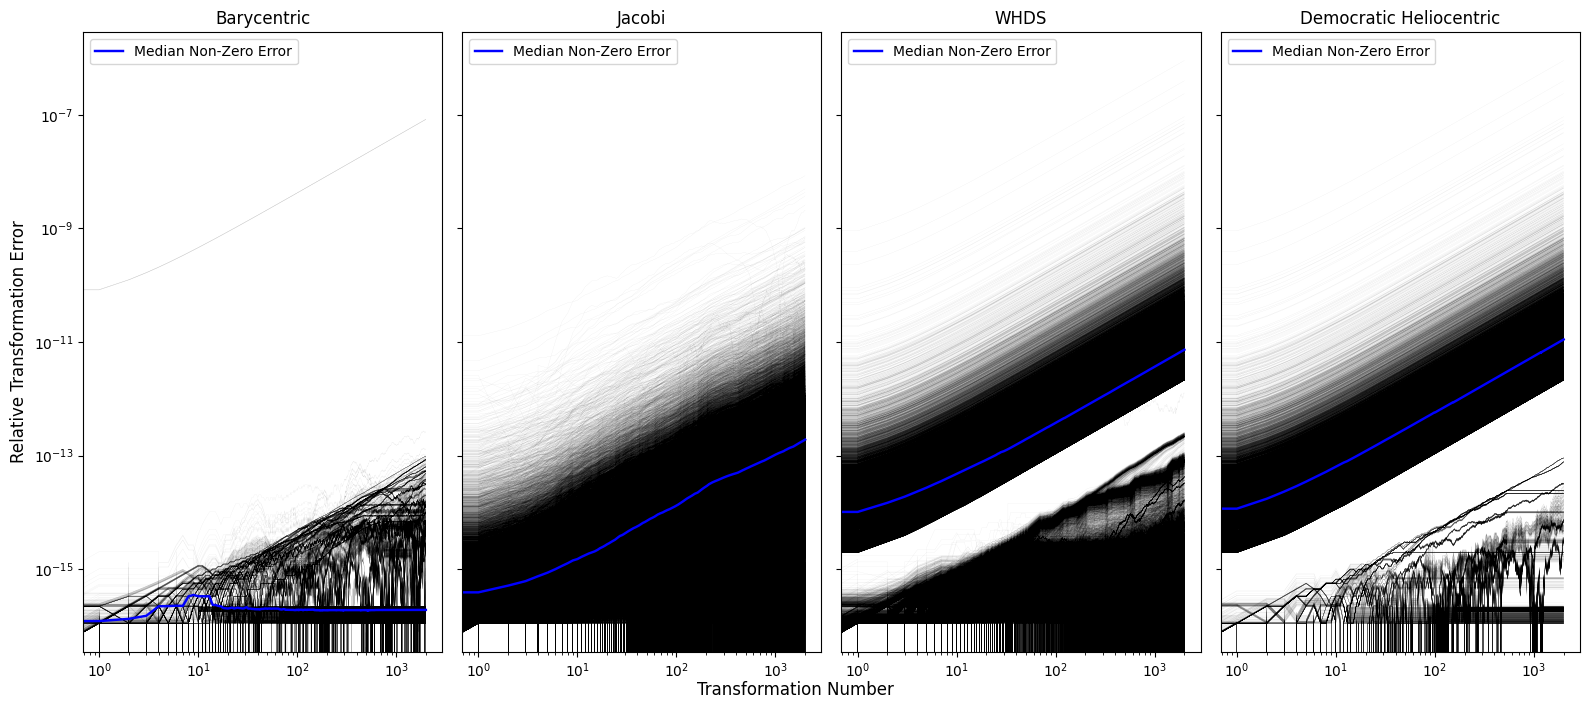

In [ ]:
import rebound
import ctypes
import numpy as np
import numpy.ma as ma
import matplotlib
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor

n_bodies = 10000
n_transforms = 2000
min=-10
max=10
m = np.abs(np.random.uniform(0.01,2,n_bodies))
x = np.random.uniform(min,max,n_bodies)
y = np.random.uniform(min,max,n_bodies)
z = np.random.uniform(min,max,n_bodies)
vx = np.random.uniform(min,max,n_bodies)
vy = np.random.uniform(min,max,n_bodies)
vz = np.random.uniform(min,max,n_bodies)

def get_particle_properties(sim):
    properties = np.zeros((sim.N,6))
    for i,p in enumerate(sim.particles):
        properties[i] = [p.x,p.y,p.z,p.vx,p.vy,p.vz]
    return properties               

def transformation_error_single(coordinate, n_transforms):
    errors = np.zeros((n_transforms, n_bodies, 6))
    sim = rebound.Simulation()
    for n in range(n_bodies):
        sim.add(m=m[n],x=x[n],y=y[n],z=z[n],vx=vx[n],vy=vy[n],vz=vz[n])
    elems = (rebound.Particle * sim.N)()
    p = ctypes.cast(elems,ctypes.POINTER(rebound.Particle))
    cl = rebound.clibrebound
    transform_from_inertial = getattr(cl,f"reb_particles_transform_inertial_to_{coordinate}_posvel")
    transform_to_inertial = getattr(cl,f"reb_particles_transform_{coordinate}_to_inertial_posvel")
    p0 = get_particle_properties(sim)
    for t in range(n_transforms):
        if t % 1000 == 0:
            print (f"{coordinate}: {(t/n_transforms)*100}%")
        if coordinate == "jacobi":
            transform_from_inertial(sim._particles,p,sim._particles,sim.N,sim.N)
            transform_to_inertial(sim._particles,p,sim._particles,sim.N,sim.N)
        else:
            transform_from_inertial(sim._particles,p,sim.N,sim.N)
            transform_to_inertial(sim._particles,p,sim.N,sim.N)
        errors[t] = np.abs((get_particle_properties(sim)-p0)/p0)
    sim = None
    return errors

def plot_errors(errors, coords):
    fig, axs = plt.subplots(1, 4, figsize=(16,7),sharex=True,sharey=True)
    axs = axs.flatten()
    for c, coord in enumerate(coords):
        axs[c].cla()
        axs[c].set_title(coord)
        axs[c].set_xscale("log")
        axs[c].set_yscale("log")
        for i in range(6):
            for n in range(n_bodies):
                axs[c].plot(range(n_transforms), errors[c][:, n, i], lw=0.05, alpha=0.3, color = "black")
        # median of non-zero errors
        errors_merged = errors[c].reshape(n_transforms, n_bodies*6)
        errors_merged[errors_merged == 0] = np.nan
        median = np.nanmedian(errors_merged, axis=1)
        axs[c].plot(range(n_transforms), median, lw=1.75, color="blue", label = "Median Non-Zero Error")
        axs[c].legend(loc="upper left")
    axs[0].set_ylabel("Relative Transformation Error", fontsize=12)
    fig.text(0.5, 0.0, 'Transformation Number', ha='center', fontsize=12)

    plt.tight_layout()
    plt.show()
    fig.savefig("rebound/testing_barycentric/transformation_errors_random.png", dpi=600)

def transformation_error(coordinates, n_transforms):
    with ThreadPoolExecutor(max_workers=24) as executor:
        results = list(executor.map(transformation_error_single, coordinates, [n_transforms] * len(coordinates)))
    return np.array(results)

errors = transformation_error(["barycentric", "jacobi", "whds", "democraticheliocentric"], n_transforms)
plot_errors(errors, ["Barycentric", "Jacobi", "WHDS", "Democratic Heliocentric"])

### Outer Solar System

Searching NASA Horizons for 'Sun'... 
Found: Sun (10) 
Searching NASA Horizons for 'Jupiter'... 
Found: Jupiter Barycenter (5) (chosen from query 'Jupiter')
Searching NASA Horizons for 'Saturn'... 
Found: Saturn Barycenter (6) (chosen from query 'Saturn')
Searching NASA Horizons for 'Uranus'... 
Searching NASA Horizons for 'Sun'... 
Found: Sun (10) 
Searching NASA Horizons for 'Jupiter'... 
Found: Uranus Barycenter (7) (chosen from query 'Uranus')
Searching NASA Horizons for 'Neptune'... 
Found: Jupiter Barycenter (5) (chosen from query 'Jupiter')
Searching NASA Horizons for 'Saturn'... 
Found: Neptune Barycenter (8) (chosen from query 'Neptune')
barycentric: 0.0%
barycentric: 0.15915492554255117%
barycentric: 0.31830985108510235%
barycentric: 0.4774647766276535%
barycentric: 0.6366197021702047%
Found: Saturn Barycenter (6) (chosen from query 'Saturn')
Searching NASA Horizons for 'Uranus'... 
barycentric: 0.7957746277127559%
Searching NASA Horizons for 'Sun'... 
barycentric: 0.95492955

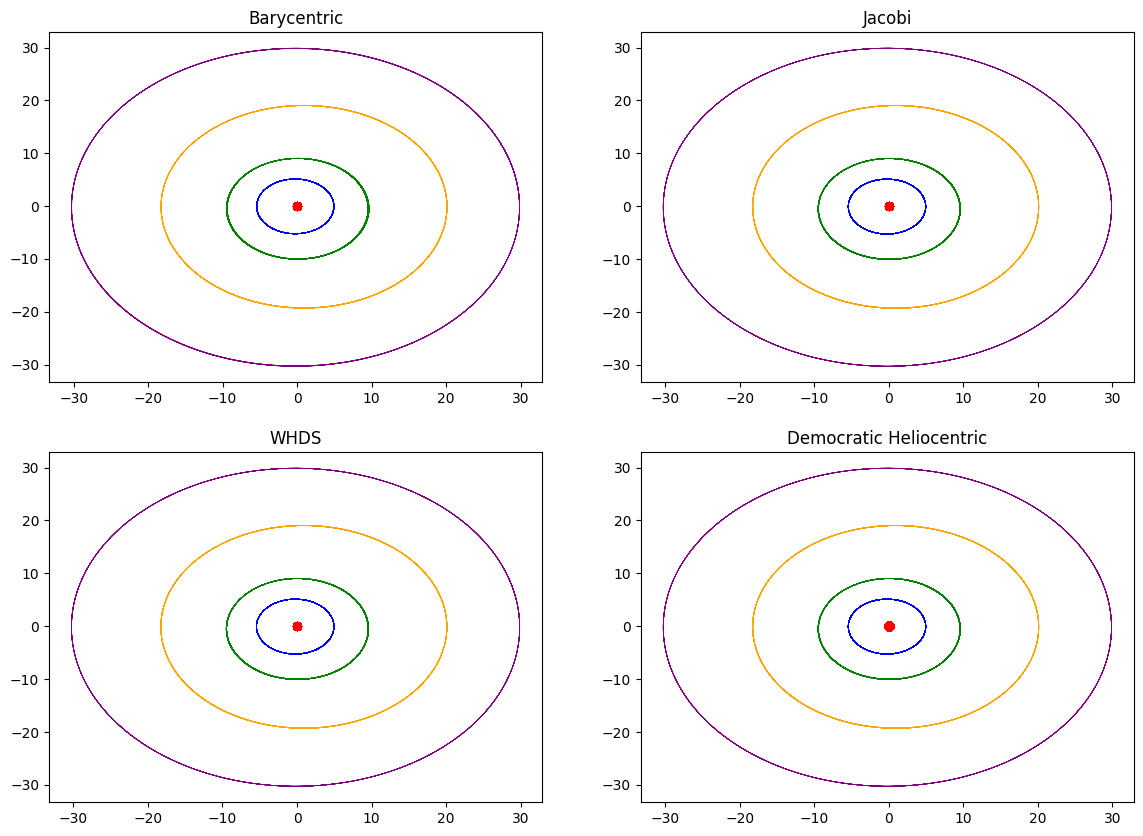

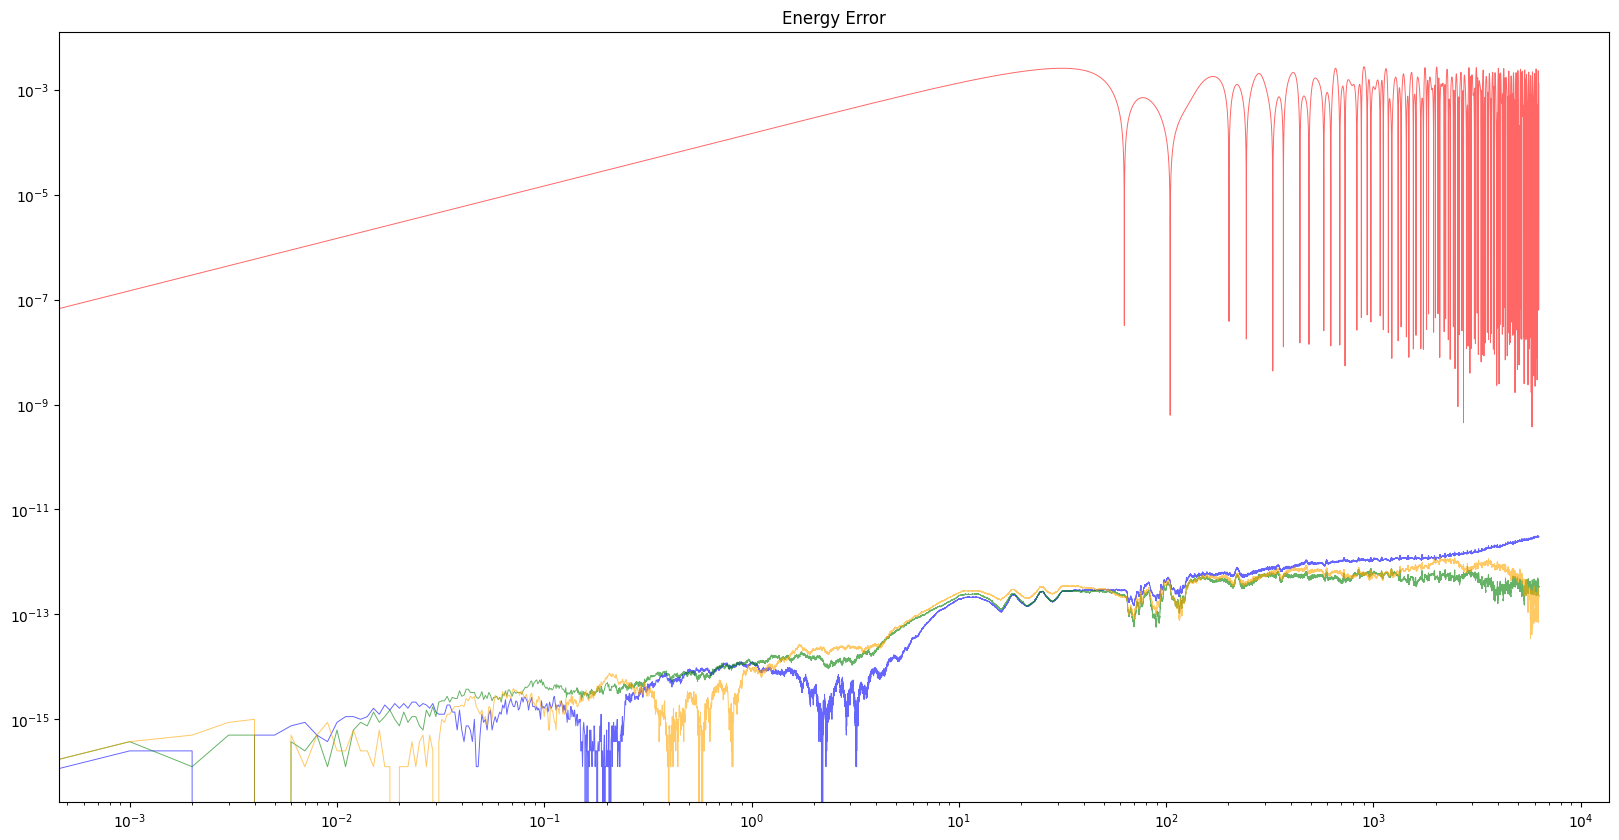

In [1]:
import rebound
import numpy as np
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
from time import sleep

n_orbits = 1000
dt =1e-3
times = np.arange(0,n_orbits*(2*np.pi), dt)
coordinates=["barycentric","jacobi","whds","democraticheliocentric"]
errors = np.zeros((len(coordinates),len(times)))
#a = np.zeros((len(coordinates),len(times),2))
x0 = np.zeros((len(coordinates),len(times)))
y0 = np.zeros((len(coordinates),len(times)))
x1 = np.zeros((len(coordinates),len(times)))
y1 = np.zeros((len(coordinates),len(times)))
x2 = np.zeros((len(coordinates),len(times)))
y2 = np.zeros((len(coordinates),len(times)))
x3 = np.zeros((len(coordinates),len(times)))
y3 = np.zeros((len(coordinates),len(times)))
x4 = np.zeros((len(coordinates),len(times)))
y4 = np.zeros((len(coordinates),len(times)))

def run_sim(coord):
    sim = rebound.Simulation()
    sim.integrator = "whfast"
    c = coordinates.index(coord)
    sleep(coordinates.index(coord)*2)
    sim.add(["Sun","Jupiter","Saturn","Uranus", "Neptune"])
    sim.move_to_com()
    sim.ri_whfast.coordinates = coord
    sim.dt = dt
    ei = sim.energy()
    for t,time in enumerate(times):
        if t % 10000 == 0:
            print(f"{coord}: {(t/len(times))*100}%")
        sim.integrate(time)
        #orbits = sim.orbits()
        # for o,orbit in enumerate(orbits):
        #     a[c,t,o] = orbit.a
        errors[c,t] = np.abs((sim.energy() - ei)/ei)
        x0[c,t] = sim.particles[0].x
        y0[c,t] = sim.particles[0].y
        x1[c,t] = sim.particles[1].x
        y1[c,t] = sim.particles[1].y
        x2[c,t] = sim.particles[2].x
        y2[c,t] = sim.particles[2].y
        x3[c,t] = sim.particles[3].x
        y3[c,t] = sim.particles[3].y
        x4[c,t] = sim.particles[4].x
        y4[c,t] = sim.particles[4].y
    #sim = None

with ThreadPoolExecutor(max_workers=24) as executor:
    executor.map(run_sim, coordinates)
 

fig, axs = plt.subplots(2, 2, figsize=(14,10))
axs = axs.flatten()
axs[0].set_title("Barycentric")
axs[0].scatter(x0[0],y0[0],label="barycentric",lw=0.5, color="red")
axs[0].plot(x1[0],y1[0],label="barycentric",lw=0.5, color="blue")
axs[0].plot(x2[0],y2[0],label="barycentric",lw=0.5, color="green")
axs[0].plot(x3[0],y3[0],label="barycentric",lw=0.5, color="orange")
axs[0].plot(x4[0],y4[0],label="barycentric",lw=0.5, color="purple")

axs[1].set_title("Jacobi")
axs[1].scatter(x0[1],y0[1],label="jacobi",lw=0.5, color="red")
axs[1].plot(x1[1],y1[1],label="jacobi",lw=0.5, color="blue")
axs[1].plot(x2[1],y2[1],label="jacobi",lw=0.5, color="green")
axs[1].plot(x3[1],y3[1],label="jacobi",lw=0.5, color="orange")
axs[1].plot(x4[1],y4[1],label="jacobi",lw=0.5, color="purple")

axs[2].set_title("WHDS")
axs[2].scatter(x0[2],y0[2],label="whds",lw=0.5, color="red")
axs[2].plot(x1[2],y1[2],label="whds",lw=0.5, color="blue")
axs[2].plot(x2[2],y2[2],label="whds",lw=0.5, color="green")
axs[2].plot(x3[2],y3[2],label="whds",lw=0.5, color="orange")
axs[2].plot(x4[2],y4[2],label="whds",lw=0.5, color="purple")

axs[3].set_title("Democratic Heliocentric")
axs[3].scatter(x0[3],y0[3],label="democraticheliocentric",lw=1, color="red")
axs[3].plot(x1[3],y1[3],label="democraticheliocentric",lw=0.5, color="blue")
axs[3].plot(x2[3],y2[3],label="democraticheliocentric",lw=0.5, color="green")
axs[3].plot(x3[3],y3[3],label="democraticheliocentric",lw=0.5, color="orange")
axs[3].plot(x4[3],y4[3],label="democraticheliocentric",lw=0.5, color="purple")

plt.show()

fig = plt.figure(figsize=(20,10))
plt.title("Energy Error")
plt.plot(times,errors[0],label="barycentric",lw=0.7, color="red", alpha=0.6)
plt.plot(times,errors[1],label="jacobi",lw=0.7, color="blue", alpha=0.6)
plt.plot(times,errors[2],label="whds",lw=0.7, color="green", alpha=0.6)
plt.plot(times,errors[3],label="democraticheliocentric",lw=0.7, color="orange", alpha=0.6)
plt.yscale("log")
plt.xscale("log")
fig.savefig("rebound/testing_barycentric/energy_error_solar_system.png", dpi=600)

# fig = plt.figure(figsize=(10,5))
# plt.title("Semi-Major Axis")
# plt.plot(times, a[0,:,0], label="barycentric",lw=0.1, color="blue", alpha=0.6)
# plt.plot(times, a[1,:,0], label="jacobi",lw=0.9, color="red", alpha=0.2)
# plt.xscale("log")
# plt.yscale("log")
# plt.legend()
# plt.show()

### 2 Bodies with Central Mass

democraticheliocentric: 0.0%
jacobi: 0.0%
whds: 0.0%
barycentric: 0.0%
democraticheliocentric: 1.591548242214544%
barycentric: 1.591548242214544%
jacobi: 1.591548242214544%
whds: 1.591548242214544%
barycentric: 3.183096484429088%
jacobi: 3.183096484429088%
democraticheliocentric: 3.183096484429088%
jacobi: 4.774644726643632%
barycentric: 4.774644726643632%
democraticheliocentric: 4.774644726643632%
jacobi: 6.366192968858176%
barycentric: 6.366192968858176%
democraticheliocentric: 6.366192968858176%
jacobi: 7.957741211072719%
barycentric: 7.957741211072719%
democraticheliocentric: 7.957741211072719%
whds: 3.183096484429088%
jacobi: 9.549289453287264%
barycentric: 9.549289453287264%
democraticheliocentric: 9.549289453287264%
barycentric: 11.140837695501807%
jacobi: 11.140837695501807%
whds: 4.774644726643632%
democraticheliocentric: 11.140837695501807%
barycentric: 12.732385937716352%
jacobi: 12.732385937716352%
whds: 6.366192968858176%
democraticheliocentric: 12.732385937716352%
barycen

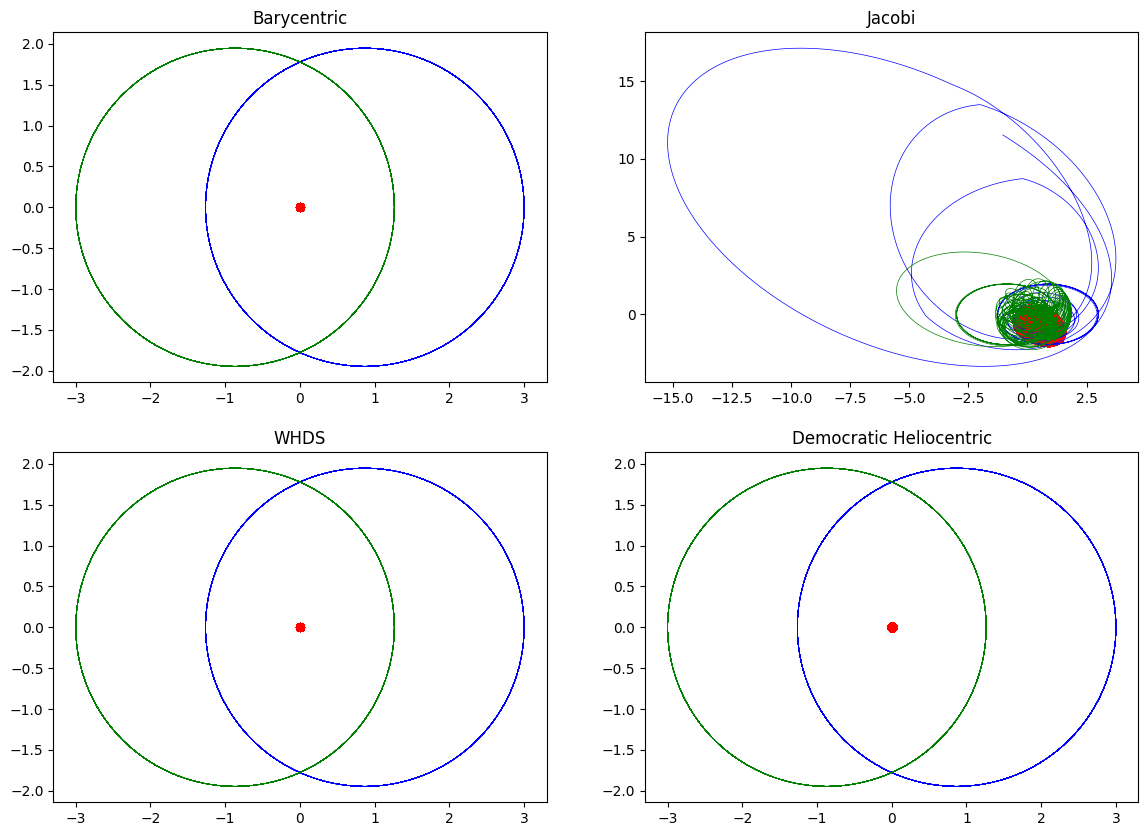

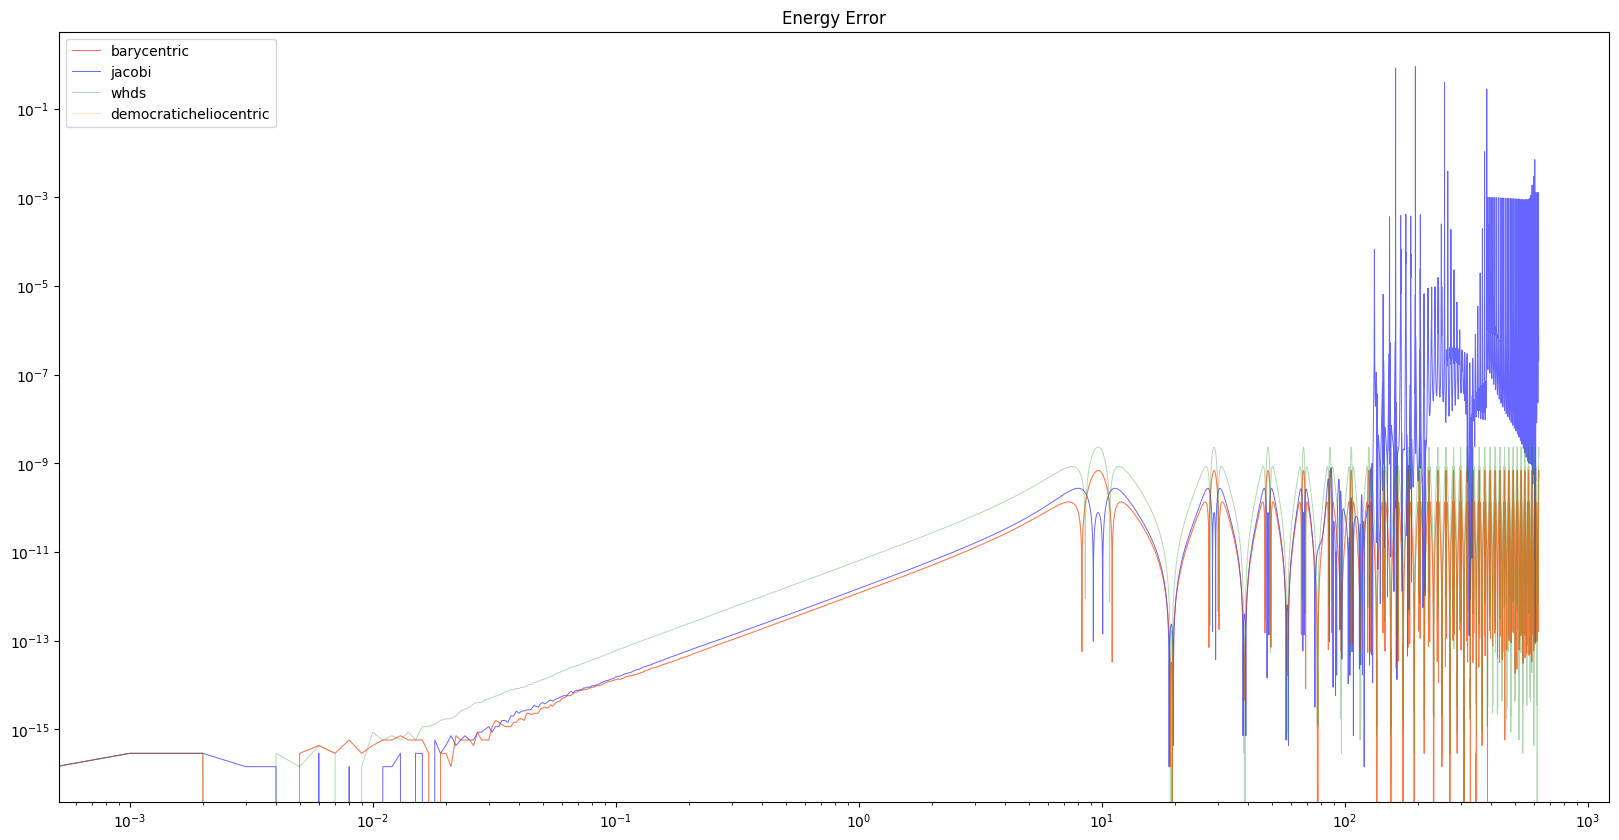

In [12]:
# 2 bodies with stationary central mass

import rebound
import numpy as np
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
n_orbits = 100
dt =1e-3
times = np.arange(0,n_orbits*(2*np.pi), dt)
coordinates=["barycentric","jacobi","whds","democraticheliocentric"]
errors = np.zeros((len(coordinates),len(times)))
#a = np.zeros((len(coordinates),len(times),2))
x0 = np.zeros((len(coordinates),len(times)))
y0 = np.zeros((len(coordinates),len(times)))
x1 = np.zeros((len(coordinates),len(times)))
y1 = np.zeros((len(coordinates),len(times)))
x2 = np.zeros((len(coordinates),len(times)))
y2 = np.zeros((len(coordinates),len(times)))
def run_sim(coord):
    sim = rebound.Simulation()
    sim.integrator = "whfast"
    c = coordinates.index(coord)
    sim.add(m=1.)
    sim.add(m=.1,x=3.,vy=0.45)
    sim.add(m=.1,x=-3.,vy=-0.45)
    sim.move_to_com()
    sim.ri_whfast.coordinates = coord
    sim.dt = dt
    ei = sim.energy()
    for t,time in enumerate(times):
        if t % 10000 == 0:
            print(f"{coord}: {(t/len(times))*100}%")
        sim.integrate(time)
        #orbits = sim.orbits()
        # for o,orbit in enumerate(orbits):
        #     a[c,t,o] = orbit.a
        errors[c,t] = np.abs((sim.energy() - ei)/ei)
        x0[c,t] = sim.particles[0].x
        y0[c,t] = sim.particles[0].y
        x1[c,t] = sim.particles[1].x
        y1[c,t] = sim.particles[1].y
        x2[c,t] = sim.particles[2].x
        y2[c,t] = sim.particles[2].y
    sim = None

with ThreadPoolExecutor() as executor:
    executor.map(run_sim, coordinates)

fig, axs = plt.subplots(2, 2, figsize=(14,10))
axs = axs.flatten()
axs[0].set_title("Barycentric")
axs[0].scatter(x0[0],y0[0],label="barycentric",lw=0.5, color="red")
axs[0].plot(x1[0],y1[0],label="barycentric",lw=0.5, color="blue")
axs[0].plot(x2[0],y2[0],label="barycentric",lw=0.5, color="green")
axs[1].set_title("Jacobi")
axs[1].scatter(x0[1],y0[1],label="jacobi",lw=0.5, color="red")
axs[1].plot(x1[1],y1[1],label="jacobi",lw=0.5, color="blue")
axs[1].plot(x2[1],y2[1],label="jacobi",lw=0.5, color="green")
axs[2].set_title("WHDS")
axs[2].scatter(x0[2],y0[2],label="whds",lw=0.5, color="red")
axs[2].plot(x1[2],y1[2],label="whds",lw=0.5, color="blue")
axs[2].plot(x2[2],y2[2],label="whds",lw=0.5, color="green")
axs[3].set_title("Democratic Heliocentric")
axs[3].scatter(x0[3],y0[3],label="democraticheliocentric",lw=1, color="red")
axs[3].plot(x1[3],y1[3],label="democraticheliocentric",lw=0.5, color="blue")
axs[3].plot(x2[3],y2[3],label="democraticheliocentric",lw=0.5, color="green")
plt.show()

fig = plt.figure(figsize=(20,10))
plt.title("Energy Error")
plt.plot(times,errors[0],label="barycentric",lw=0.7, color="red", alpha=0.6)
plt.plot(times,errors[1],label="jacobi",lw=0.7, color="blue", alpha=0.6)
plt.plot(times,errors[2],label="whds",lw=0.7, color="green", alpha=0.3)
plt.plot(times,errors[3],label="democraticheliocentric",lw=0.7, color="orange", alpha=0.3)
plt.yscale("log")
plt.xscale("log")
plt.legend()
fig.savefig("rebound/testing_barycentric/energy_error_3_body.png", dpi=600)

# fig = plt.figure(figsize=(10,5))
# plt.title("Semi-Major Axis")
# plt.plot(times, a[0,:,0], label="barycentric",lw=0.1, color="blue", alpha=0.6)
# plt.plot(times, a[1,:,0], label="jacobi",lw=0.9, color="red", alpha=0.2)
# plt.xscale("log")
# plt.yscale("log")
# plt.legend()
# plt.show()

### 6 Bodies with Central Mass

jacobi: 0.0%barycentric: 0.0%

whds: 0.0%
democraticheliocentric: 0.0%
barycentric: 0.5305163621856426%
democraticheliocentric: 0.5305163621856426%
jacobi: 0.5305163621856426%
whds: 0.5305163621856426%
barycentric: 1.0610327243712852%
democraticheliocentric: 1.0610327243712852%
jacobi: 1.0610327243712852%
whds: 1.0610327243712852%
barycentric: 1.5915490865569277%
democraticheliocentric: 1.5915490865569277%
jacobi: 1.5915490865569277%
whds: 1.5915490865569277%
barycentric: 2.1220654487425703%
democraticheliocentric: 2.1220654487425703%
jacobi: 2.1220654487425703%
whds: 2.1220654487425703%
barycentric: 2.6525818109282127%
democraticheliocentric: 2.6525818109282127%
jacobi: 2.6525818109282127%
whds: 2.6525818109282127%
barycentric: 3.1830981731138555%
democraticheliocentric: 3.1830981731138555%
jacobi: 3.1830981731138555%
whds: 3.1830981731138555%
barycentric: 3.713614535299498%
democraticheliocentric: 3.713614535299498%
jacobi: 3.713614535299498%
whds: 3.713614535299498%
barycentric: 4.2

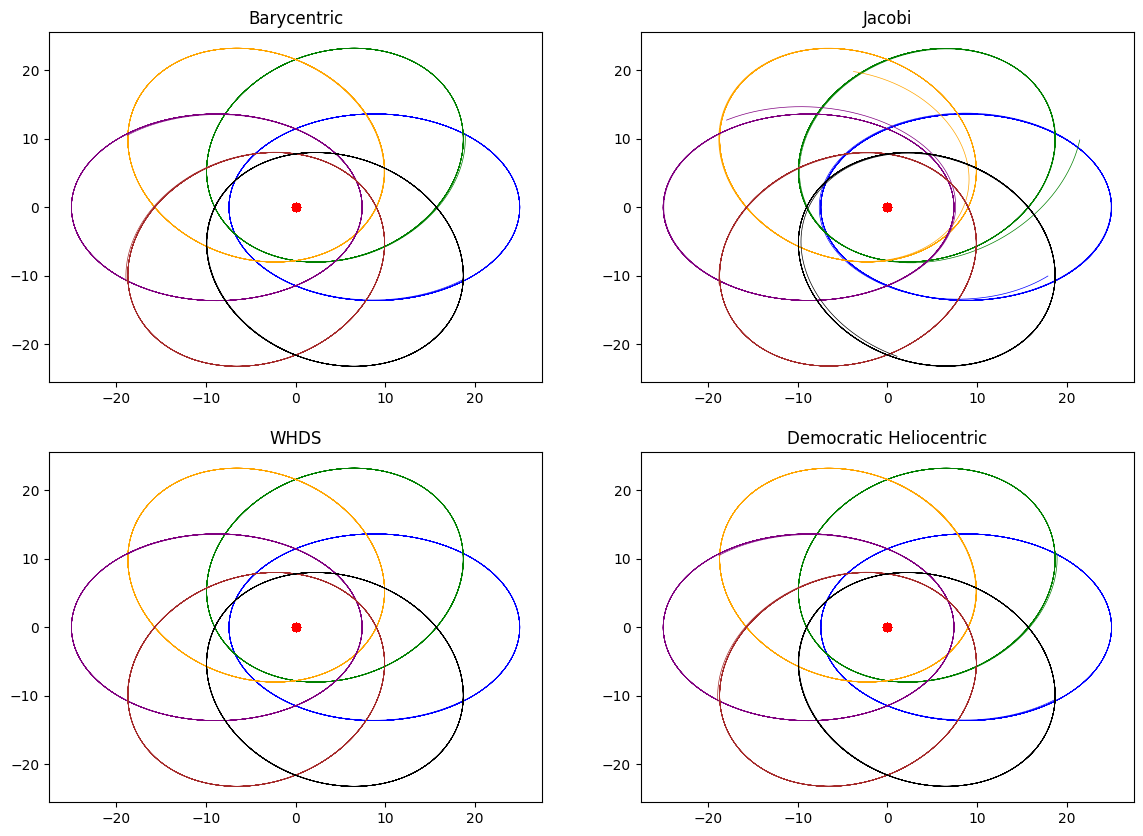

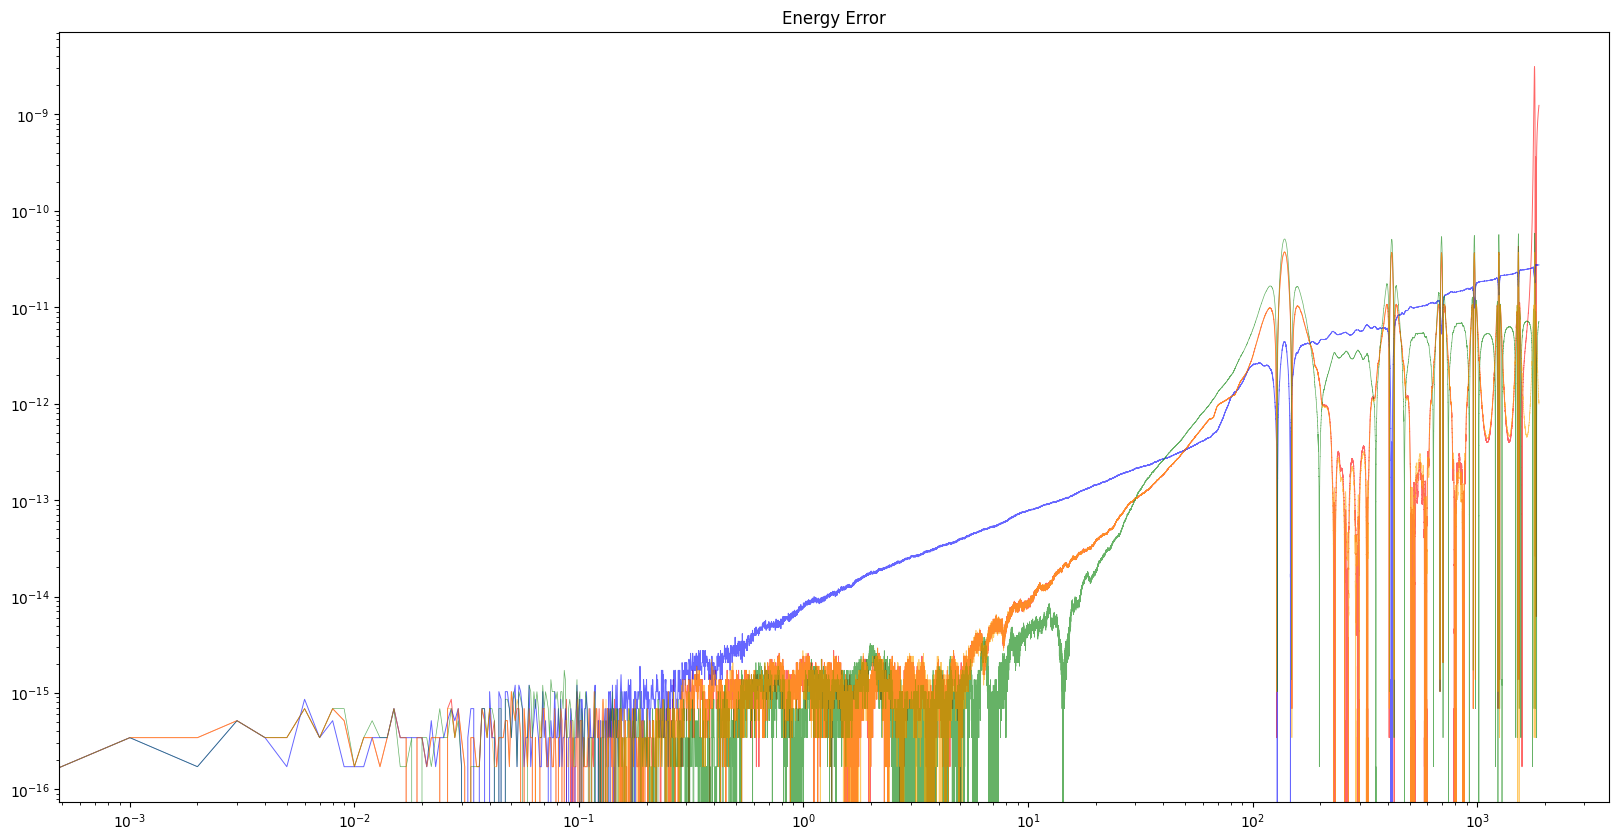

In [9]:
import rebound
import numpy as np
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
n_orbits = 300
dt =1e-3
times = np.arange(0,n_orbits*(2*np.pi), dt)
coordinates=["barycentric","jacobi","whds","democraticheliocentric"]
errors = np.zeros((len(coordinates),len(times)))
x0 = np.zeros((len(coordinates),len(times)))
y0 = np.zeros((len(coordinates),len(times)))
x1 = np.zeros((len(coordinates),len(times)))
y1 = np.zeros((len(coordinates),len(times)))
x2 = np.zeros((len(coordinates),len(times)))
y2 = np.zeros((len(coordinates),len(times)))
x3 = np.zeros((len(coordinates),len(times)))
y3 = np.zeros((len(coordinates),len(times)))
x4 = np.zeros((len(coordinates),len(times)))
y4 = np.zeros((len(coordinates),len(times)))
x5 = np.zeros((len(coordinates),len(times)))
y5 = np.zeros((len(coordinates),len(times)))
x6 = np.zeros((len(coordinates),len(times)))
y6 = np.zeros((len(coordinates),len(times)))

def run_sim(coord):
    sim = rebound.Simulation()
    sim.integrator = "whfast"
    c = coordinates.index(coord)
   
    d=25
    v=0.2
    sim.add(m=2., x=0., y=0., z=0., vx=0., vy=0., vz=0.)
    for i in range(6):
        angle = i * np.pi / 3
        x = d * np.cos(angle)
        y = d * np.sin(angle)
        vx = -v * np.sin(angle)
        vy = v * np.cos(angle)
        sim.add(m=.1, x=x, y=y, z=0., vx=vx, vy=vy, vz=0.)
    
    sim.move_to_com()
    sim.ri_whfast.coordinates = coord
    sim.dt = dt
    ei = sim.energy()
    for t,time in enumerate(times):
        if t % 10000 == 0:
            print(f"{coord}: {(t/len(times))*100}%")
        sim.integrate(time)
        errors[c,t] = np.abs((sim.energy() - ei)/ei)
        x0[c,t] = sim.particles[0].x
        y0[c,t] = sim.particles[0].y
        x1[c,t] = sim.particles[1].x
        y1[c,t] = sim.particles[1].y
        x2[c,t] = sim.particles[2].x
        y2[c,t] = sim.particles[2].y
        x3[c,t] = sim.particles[3].x
        y3[c,t] = sim.particles[3].y
        x4[c,t] = sim.particles[4].x
        y4[c,t] = sim.particles[4].y
        x5[c,t] = sim.particles[5].x
        y5[c,t] = sim.particles[5].y
        x6[c,t] = sim.particles[6].x
        y6[c,t] = sim.particles[6].y

    sim = None

with ThreadPoolExecutor() as executor:
    executor.map(run_sim, coordinates)

fig, axs = plt.subplots(2, 2, figsize=(14,10))
axs = axs.flatten()
axs[0].set_title("Barycentric")
axs[0].scatter(x0[0],y0[0],label="barycentric",lw=0.5, color="red")
axs[0].plot(x1[0],y1[0],label="barycentric",lw=0.5, color="blue")
axs[0].plot(x2[0],y2[0],label="barycentric",lw=0.5, color="green")
axs[0].plot(x3[0],y3[0],label="barycentric",lw=0.5, color="orange")
axs[0].plot(x4[0],y4[0],label="barycentric",lw=0.5, color="purple")
axs[0].plot(x5[0],y5[0],label="barycentric",lw=0.5, color="brown")
axs[0].plot(x6[0],y6[0],label="barycentric",lw=0.5, color="black")


axs[1].set_title("Jacobi")
axs[1].scatter(x0[1],y0[1],label="jacobi",lw=0.5, color="red")
axs[1].plot(x1[1],y1[1],label="jacobi",lw=0.5, color="blue")
axs[1].plot(x2[1],y2[1],label="jacobi",lw=0.5, color="green")
axs[1].plot(x3[1],y3[1],label="jacobi",lw=0.5, color="orange")
axs[1].plot(x4[1],y4[1],label="jacobi",lw=0.5, color="purple")
axs[1].plot(x5[1],y5[1],label="jacobi",lw=0.5, color="brown")
axs[1].plot(x6[1],y6[1],label="jacobi",lw=0.5, color="black")

axs[2].set_title("WHDS")
axs[2].scatter(x0[2],y0[2],label="whds",lw=0.5, color="red")
axs[2].plot(x1[2],y1[2],label="whds",lw=0.5, color="blue")
axs[2].plot(x2[2],y2[2],label="whds",lw=0.5, color="green")
axs[2].plot(x3[2],y3[2],label="whds",lw=0.5, color="orange")
axs[2].plot(x4[2],y4[2],label="whds",lw=0.5, color="purple")
axs[2].plot(x5[2],y5[2],label="whds",lw=0.5, color="brown")
axs[2].plot(x6[2],y6[2],label="whds",lw=0.5, color="black")

axs[3].set_title("Democratic Heliocentric")
axs[3].scatter(x0[3],y0[3],label="democraticheliocentric",lw=0.5, color="red")
axs[3].plot(x1[3],y1[3],label="democraticheliocentric",lw=0.5, color="blue")
axs[3].plot(x2[3],y2[3],label="democraticheliocentric",lw=0.5, color="green")
axs[3].plot(x3[3],y3[3],label="democraticheliocentric",lw=0.5, color="orange")
axs[3].plot(x4[3],y4[3],label="democraticheliocentric",lw=0.5, color="purple")
axs[3].plot(x5[3],y5[3],label="democraticheliocentric",lw=0.5, color="brown")
axs[3].plot(x6[3],y6[3],label="democraticheliocentric",lw=0.5, color="black")
plt.show()

fig = plt.figure(figsize=(20,10))
plt.title("Energy Error")
plt.plot(times,errors[0],label="barycentric",lw=0.7, color="red", alpha=0.6)
plt.plot(times,errors[1],label="jacobi",lw=0.7, color="blue", alpha=0.6)
plt.plot(times,errors[2],label="whds",lw=0.5, color="green", alpha=0.6)
plt.plot(times,errors[3],label="democraticheliocentric",lw=0.5, color="orange", alpha=0.6)
plt.yscale("log")
plt.xscale("log")
fig.savefig("rebound/testing_barycentric/energy_error_7_body.png", dpi=600)

# fig = plt.figure(figsize=(10,5))
# plt.title("Semi-Major Axis")
# plt.plot(times, a[0,:,0], label="barycentric",lw=0.1, color="blue", alpha=0.6)
# plt.plot(times, a[1,:,0], label="jacobi",lw=0.9, color="red", alpha=0.2)
# plt.xscale("log")
# plt.yscale("log")
# plt.legend()
# plt.show()